<a href="https://colab.research.google.com/github/vaibhavlokunde/AI-ML/blob/main/GAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch,pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [27]:
def show(tensor,ch=1,size=(28,28),num=16):
  data=tensor.detach().cpu().view(-1,ch,*size)
  grid=make_grid(data[:num],nrow=4).permute(1,2,0)
  plt.imshow(grid)
  plt.axis('off')
  plt.show()

In [42]:
epochs=50
cur_step=0
info_step=300
mean_gen_loss=0
mean_disc_loss=0

z_dim=64
lr=0.001
loss_fn=nn.BCEWithLogitsLoss()
bs=128
device="cuda"

In [43]:
data=DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),batch_size=bs,shuffle=True)

In [44]:
def genBlock(inp,out):
  return nn.Sequential(
    nn.Linear(inp,out),
    nn.BatchNorm1d(out),
    nn.ReLU(inplace=True)
  )

In [45]:
class Generator(nn.Module):
  def __init__(self,z_dim=64,i_dim=784,hidden_dim=128):
    super(Generator,self).__init__()
    self.gen=nn.Sequential(
      genBlock(z_dim,hidden_dim),
      genBlock(hidden_dim,hidden_dim*2),
      genBlock(hidden_dim*2,hidden_dim*4),
      genBlock(hidden_dim*4,hidden_dim*8),
      nn.Linear(hidden_dim*8,i_dim),
      nn.Sigmoid()
    )
  def forward(self,noise):
    return self.gen(noise)

In [46]:
def discBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

In [47]:
class Discriminator(nn.Module):
  def __init__(self,i_dim=784,hidden_dim=256):
    super(Discriminator,self).__init__()
    self.disc=nn.Sequential(
      discBlock(i_dim,hidden_dim*4),
      discBlock(hidden_dim*4,hidden_dim*2),
      discBlock(hidden_dim*2,hidden_dim),
      nn.Linear(hidden_dim,1)
    )
  def forward(self,image):
    return self.disc(image)

In [48]:
def gen_noise(number,z_dim):
  return torch.randn(number,z_dim).to(device)

In [49]:
gen=Generator(z_dim).to(device)
gen_opt=torch.optim.Adam(gen.parameters(),lr=lr)
disc=Discriminator().to(device)
disc_opt=torch.optim.Adam(disc.parameters(),lr=lr)

In [50]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [51]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([3, 2, 4, 7, 0, 1, 2, 3, 2, 3])


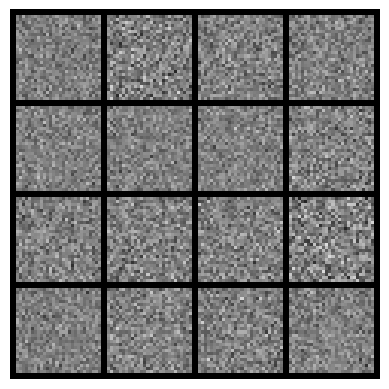

In [52]:
X,y=next(iter(data))
print(X.shape,y.shape)
print(y[:10])

noise=gen_noise(bs,z_dim)
fake=gen(noise)
show(fake)

In [53]:
def calc_gen_loss(loss_fn,gen,disc,number,z_dim):
  noise = gen_noise(number,z_dim)
  fake = gen(noise)
  pred=disc(fake)
  targets=torch.ones_like(pred)
  gen_loss=loss_fn(pred,targets)
  return gen_loss

In [54]:
def calc_disc_loss(loss_fn,gen,disc,real,number,z_dim):
  noise=gen_noise(number,z_dim)
  fake=gen(noise)
  disc_fake_pred=disc(fake.detach())
  disc_fake_targets=torch.zeros_like(disc_fake_pred)
  disc_fake_loss=loss_fn(disc_fake_pred,disc_fake_targets)

  disc_real_pred=disc(real)
  disc_real_targets=torch.ones_like(disc_real_pred)
  disc_real_loss=loss_fn(disc_real_pred,disc_real_targets)

  disc_loss=(disc_fake_loss+disc_real_loss)/2
  return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

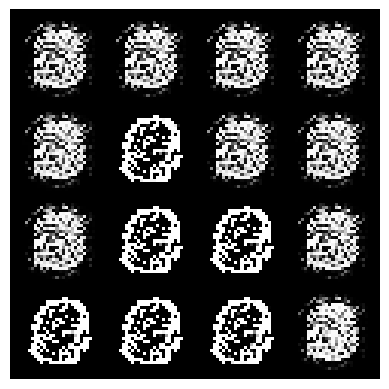

Epoch 0, step 300: Generator loss: 11.470759546756751, discriminator loss: 0.16524060730526485


  0%|          | 0/469 [00:00<?, ?it/s]

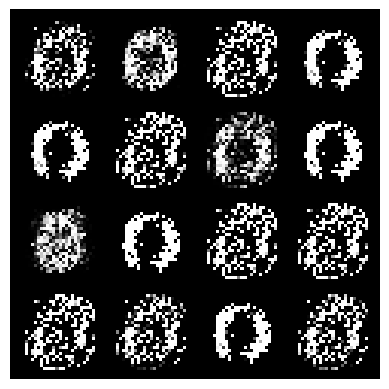

Epoch 1, step 600: Generator loss: 15.50347010930379, discriminator loss: 0.04712464286746886


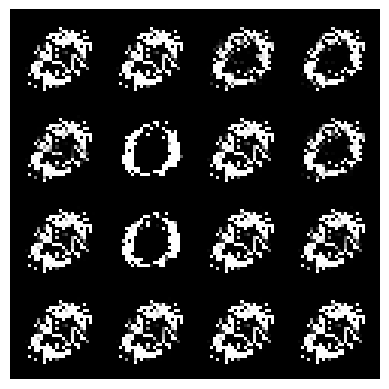

Epoch 1, step 900: Generator loss: 13.018320846557618, discriminator loss: 0.016231206694792482


  0%|          | 0/469 [00:00<?, ?it/s]

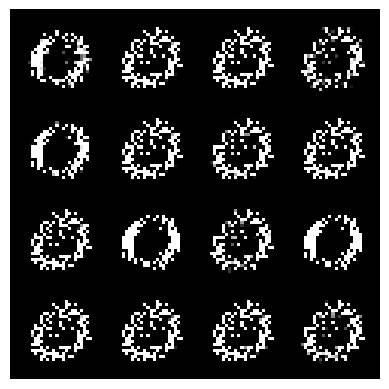

Epoch 2, step 1200: Generator loss: 12.651667051315316, discriminator loss: 0.025563843748556494


  0%|          | 0/469 [00:00<?, ?it/s]

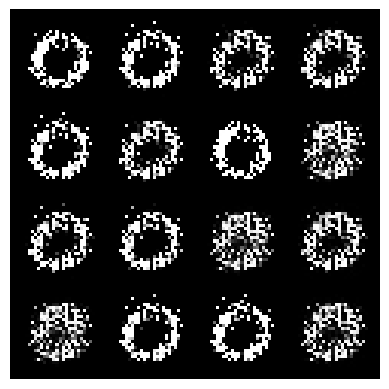

Epoch 3, step 1500: Generator loss: 15.221538480122888, discriminator loss: 0.020697900697947868


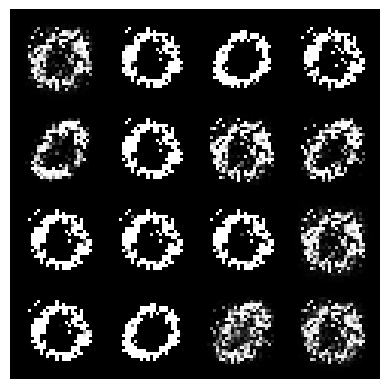

Epoch 3, step 1800: Generator loss: 13.686522382100424, discriminator loss: 0.010304698604838134


  0%|          | 0/469 [00:00<?, ?it/s]

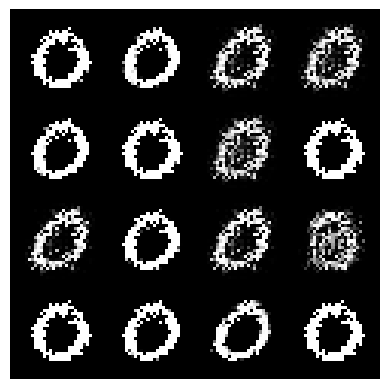

Epoch 4, step 2100: Generator loss: 12.846682526270554, discriminator loss: 0.032177217212894973


  0%|          | 0/469 [00:00<?, ?it/s]

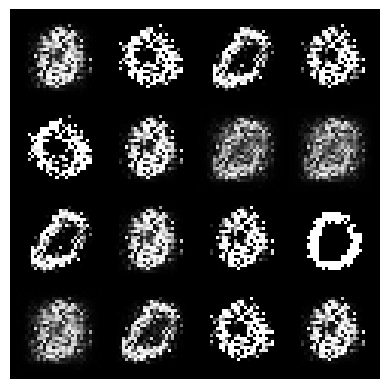

Epoch 5, step 2400: Generator loss: 10.730426818529759, discriminator loss: 0.022713446280831703


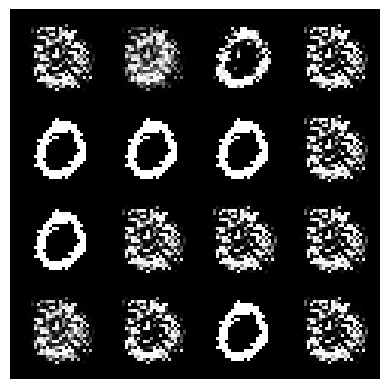

Epoch 5, step 2700: Generator loss: 9.900865020751947, discriminator loss: 0.033242972276736164


  0%|          | 0/469 [00:00<?, ?it/s]

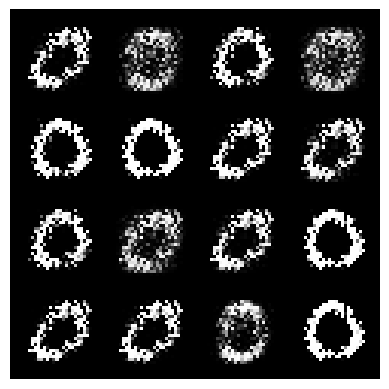

Epoch 6, step 3000: Generator loss: 10.51924444993337, discriminator loss: 0.01983708232660623


  0%|          | 0/469 [00:00<?, ?it/s]

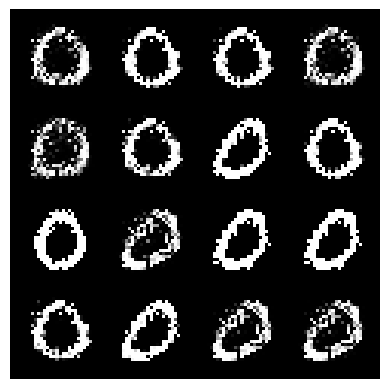

Epoch 7, step 3300: Generator loss: 10.622704049746192, discriminator loss: 0.022685118724524878


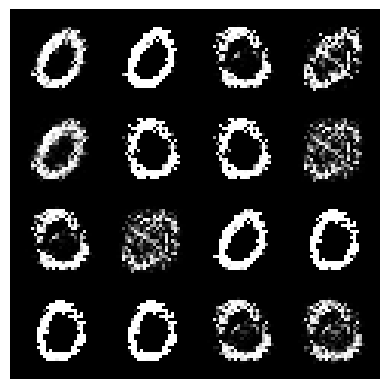

Epoch 7, step 3600: Generator loss: 12.124028207461045, discriminator loss: 0.04682759533553813


  0%|          | 0/469 [00:00<?, ?it/s]

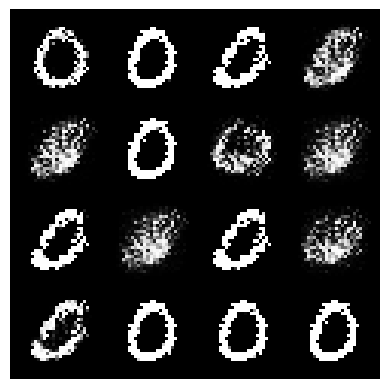

Epoch 8, step 3900: Generator loss: 11.61639193137487, discriminator loss: 0.039471539121659564


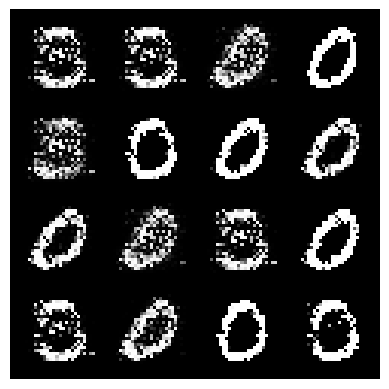

Epoch 8, step 4200: Generator loss: 9.0938206243515, discriminator loss: 0.03466535016988929


  0%|          | 0/469 [00:00<?, ?it/s]

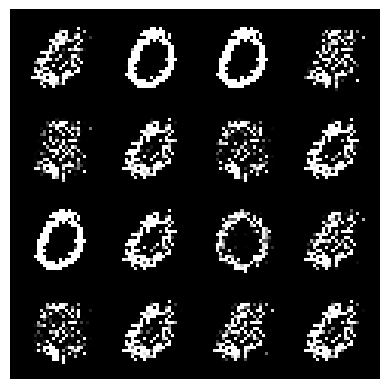

Epoch 9, step 4500: Generator loss: 9.760063255627957, discriminator loss: 0.041945750920955684


  0%|          | 0/469 [00:00<?, ?it/s]

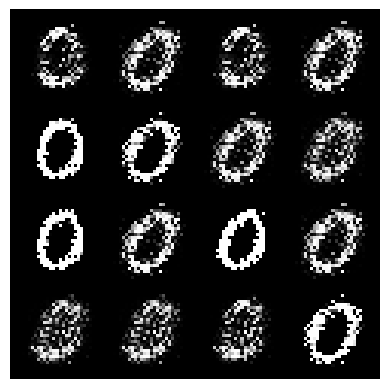

Epoch 10, step 4800: Generator loss: 13.068583499590552, discriminator loss: 0.04318360092946328


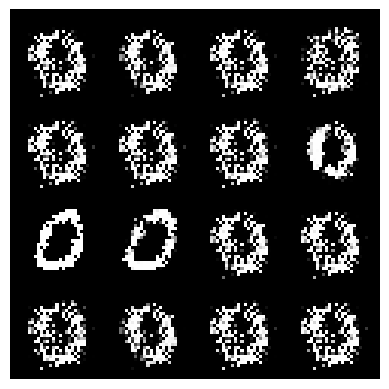

Epoch 10, step 5100: Generator loss: 13.809048951466883, discriminator loss: 0.04219344425333303


  0%|          | 0/469 [00:00<?, ?it/s]

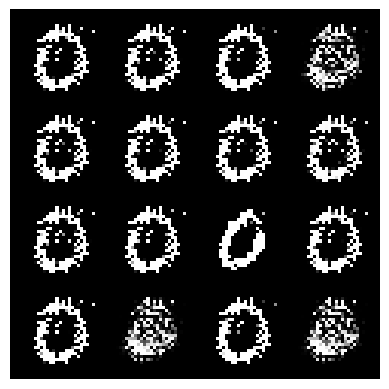

Epoch 11, step 5400: Generator loss: 11.298124154408768, discriminator loss: 0.019086944439428995


  0%|          | 0/469 [00:00<?, ?it/s]

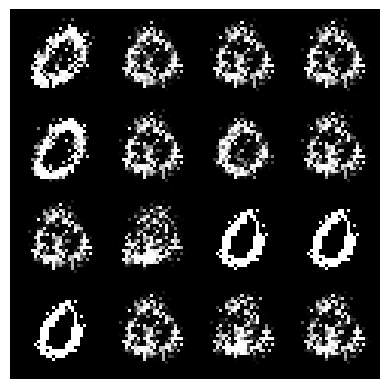

Epoch 12, step 5700: Generator loss: 12.838680715560903, discriminator loss: 0.0362982509340509


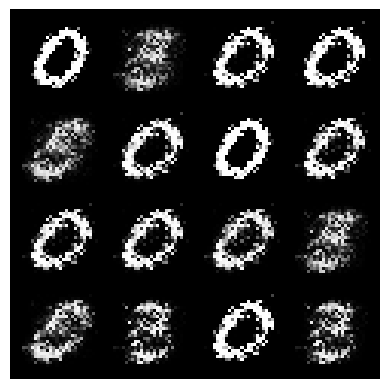

Epoch 12, step 6000: Generator loss: 9.418845403989161, discriminator loss: 0.052547655226662764


  0%|          | 0/469 [00:00<?, ?it/s]

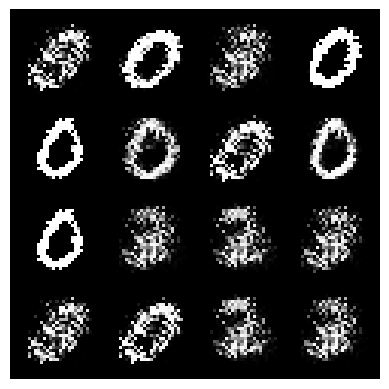

Epoch 13, step 6300: Generator loss: 10.370209358533225, discriminator loss: 0.07090768439016149


  0%|          | 0/469 [00:00<?, ?it/s]

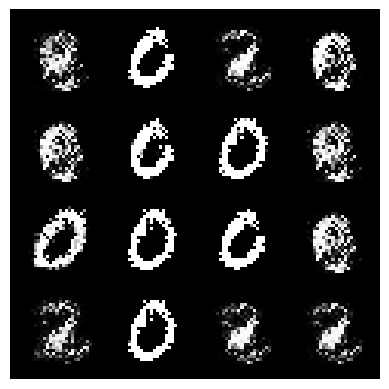

Epoch 14, step 6600: Generator loss: 8.369860574404395, discriminator loss: 0.04463687811163248


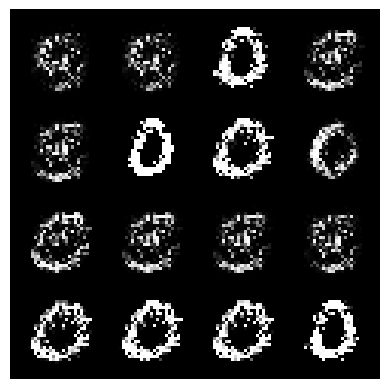

Epoch 14, step 6900: Generator loss: 9.736145394643145, discriminator loss: 0.03837411556557828


  0%|          | 0/469 [00:00<?, ?it/s]

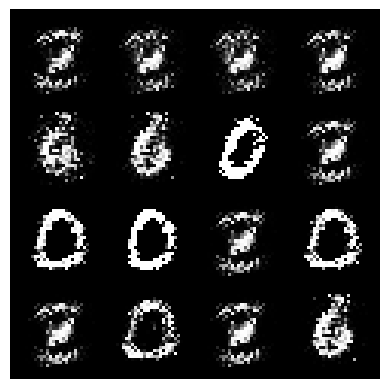

Epoch 15, step 7200: Generator loss: 9.22145035584768, discriminator loss: 0.03627199992712122


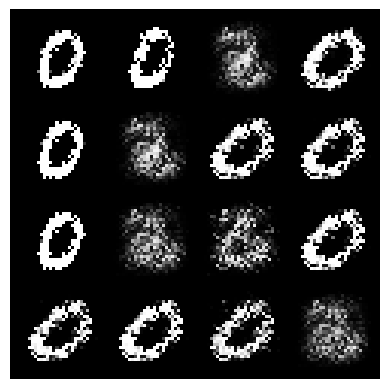

Epoch 15, step 7500: Generator loss: 11.753451895713813, discriminator loss: 0.049015486799665574


  0%|          | 0/469 [00:00<?, ?it/s]

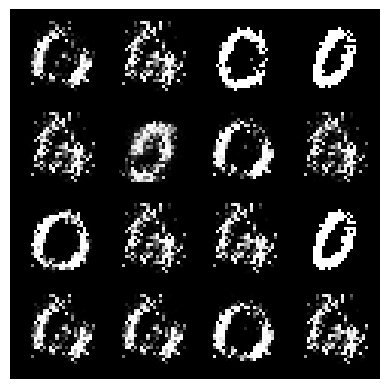

Epoch 16, step 7800: Generator loss: 11.14692770163218, discriminator loss: 0.04639586422359569


  0%|          | 0/469 [00:00<?, ?it/s]

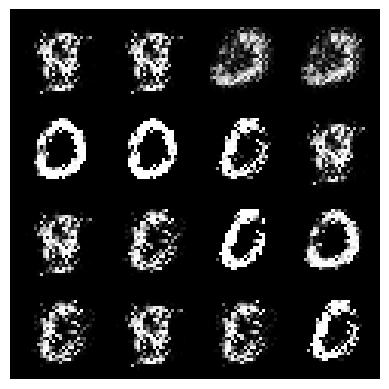

Epoch 17, step 8100: Generator loss: 8.803119726181025, discriminator loss: 0.05063550854839078


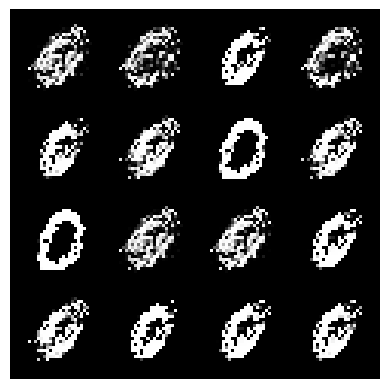

Epoch 17, step 8400: Generator loss: 8.89009666760762, discriminator loss: 0.04606257254451825


  0%|          | 0/469 [00:00<?, ?it/s]

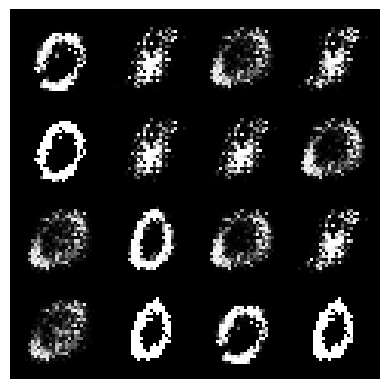

Epoch 18, step 8700: Generator loss: 9.24822820186614, discriminator loss: 0.06372598407052768


  0%|          | 0/469 [00:00<?, ?it/s]

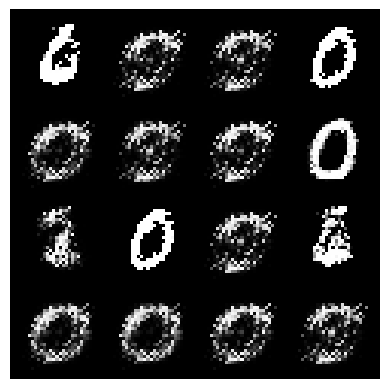

Epoch 19, step 9000: Generator loss: 8.855677838325496, discriminator loss: 0.041982184060422395


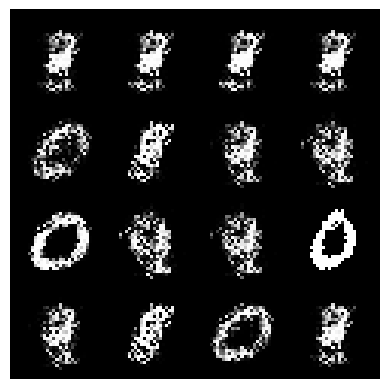

Epoch 19, step 9300: Generator loss: 9.429261938730876, discriminator loss: 0.044046433233112706


  0%|          | 0/469 [00:00<?, ?it/s]

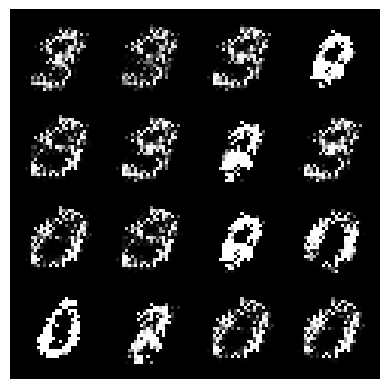

Epoch 20, step 9600: Generator loss: 8.698565231959028, discriminator loss: 0.04109368381245684


  0%|          | 0/469 [00:00<?, ?it/s]

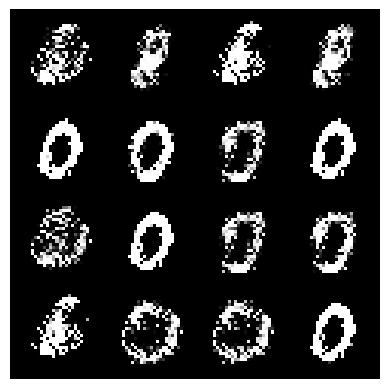

Epoch 21, step 9900: Generator loss: 10.129077151616416, discriminator loss: 0.04473304422805087


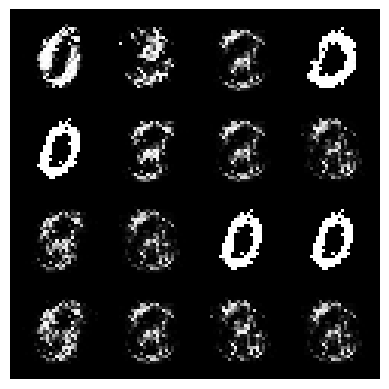

Epoch 21, step 10200: Generator loss: 9.17241723775863, discriminator loss: 0.05248730371162918


  0%|          | 0/469 [00:00<?, ?it/s]

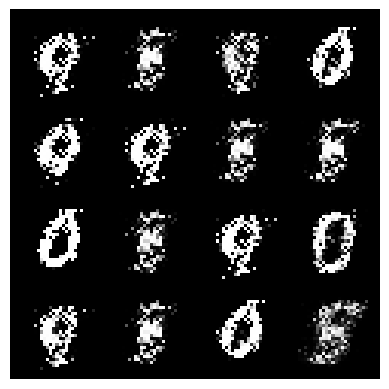

Epoch 22, step 10500: Generator loss: 9.316041968663532, discriminator loss: 0.06240702742322654


  0%|          | 0/469 [00:00<?, ?it/s]

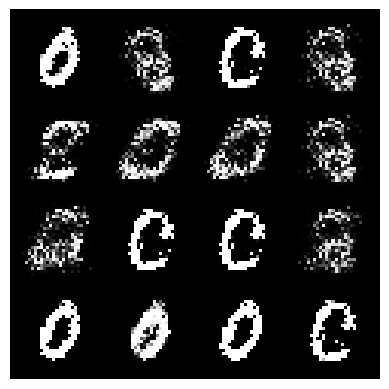

Epoch 23, step 10800: Generator loss: 9.680689981778459, discriminator loss: 0.06637997863891844


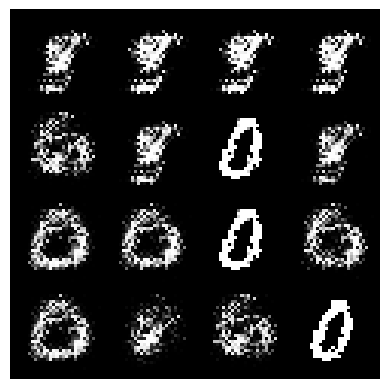

Epoch 23, step 11100: Generator loss: 9.350824966430663, discriminator loss: 0.04421460368204859


  0%|          | 0/469 [00:00<?, ?it/s]

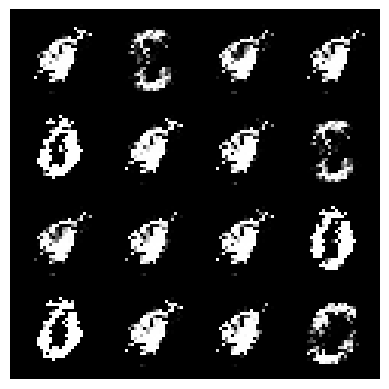

Epoch 24, step 11400: Generator loss: 8.473460555076604, discriminator loss: 0.05772949839631716


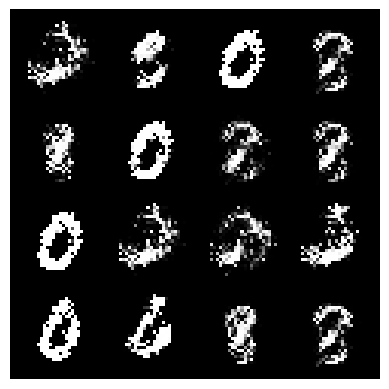

Epoch 24, step 11700: Generator loss: 7.978598925272622, discriminator loss: 0.05155850032034021


  0%|          | 0/469 [00:00<?, ?it/s]

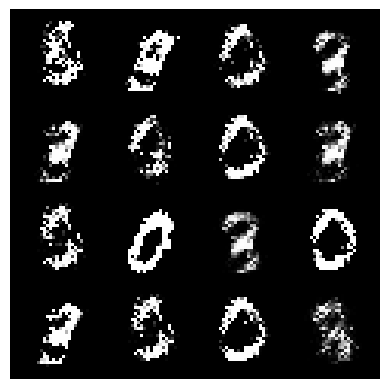

Epoch 25, step 12000: Generator loss: 8.401440440813703, discriminator loss: 0.053162101230894515


  0%|          | 0/469 [00:00<?, ?it/s]

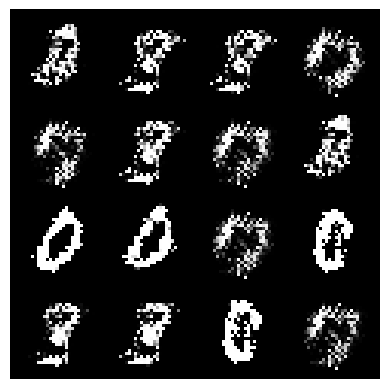

Epoch 26, step 12300: Generator loss: 8.709714282353723, discriminator loss: 0.04947195846044143


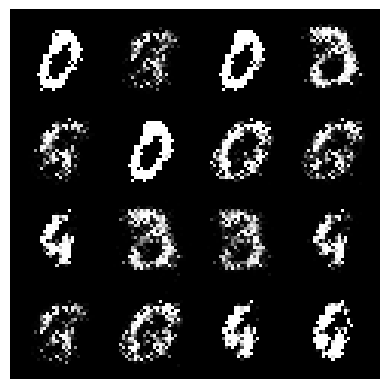

Epoch 26, step 12600: Generator loss: 9.029695808092756, discriminator loss: 0.05276794798206535


  0%|          | 0/469 [00:00<?, ?it/s]

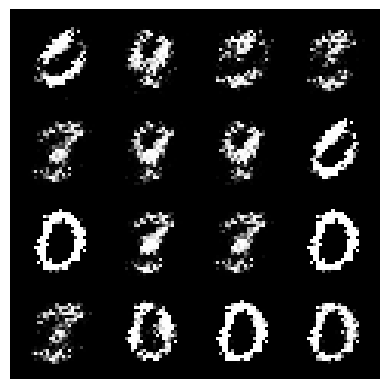

Epoch 27, step 12900: Generator loss: 10.294784824053437, discriminator loss: 0.04833216824646419


  0%|          | 0/469 [00:00<?, ?it/s]

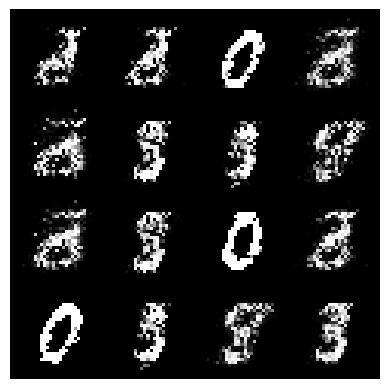

Epoch 28, step 13200: Generator loss: 7.731759263674412, discriminator loss: 0.04765331970372543


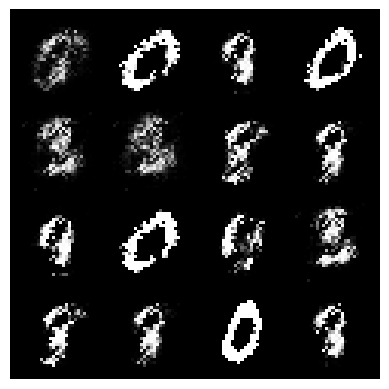

Epoch 28, step 13500: Generator loss: 7.861927261352542, discriminator loss: 0.05883531571521112


  0%|          | 0/469 [00:00<?, ?it/s]

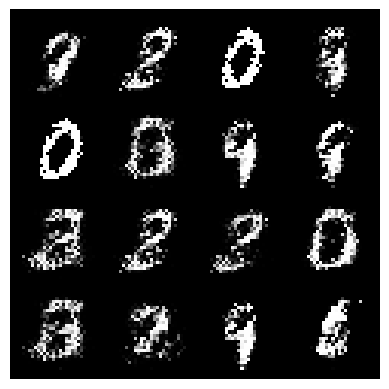

Epoch 29, step 13800: Generator loss: 8.011072926521305, discriminator loss: 0.05710910072550173


  0%|          | 0/469 [00:00<?, ?it/s]

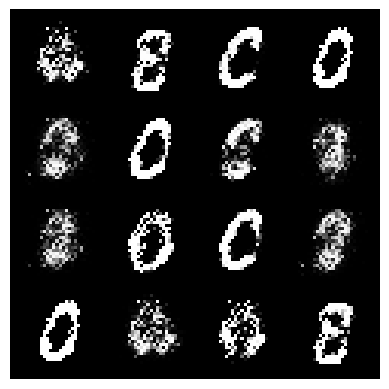

Epoch 30, step 14100: Generator loss: 8.485784265200301, discriminator loss: 0.05285501202723633


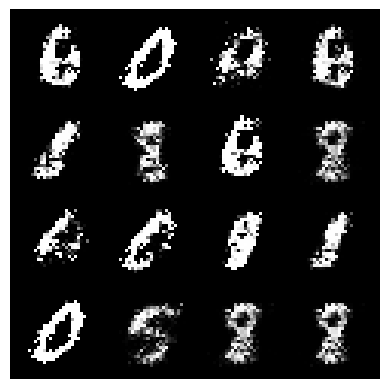

Epoch 30, step 14400: Generator loss: 7.802519961992901, discriminator loss: 0.05463329663034528


  0%|          | 0/469 [00:00<?, ?it/s]

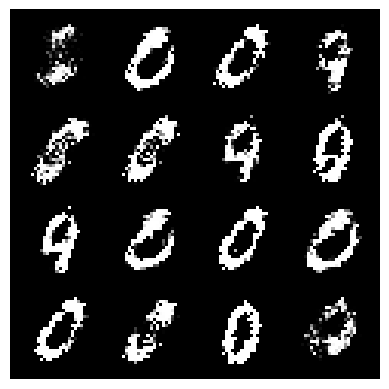

Epoch 31, step 14700: Generator loss: 7.274512594540915, discriminator loss: 0.05704565896652644


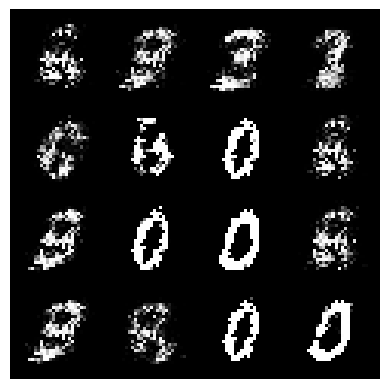

Epoch 31, step 15000: Generator loss: 7.394569741884866, discriminator loss: 0.05676082494979101


  0%|          | 0/469 [00:00<?, ?it/s]

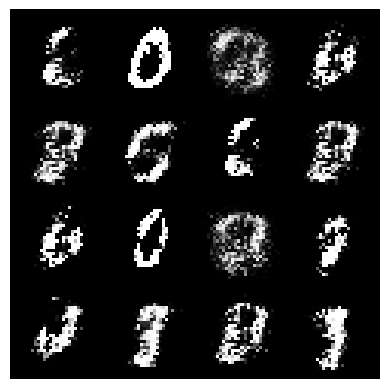

Epoch 32, step 15300: Generator loss: 8.481698204676306, discriminator loss: 0.05870264723353706


  0%|          | 0/469 [00:00<?, ?it/s]

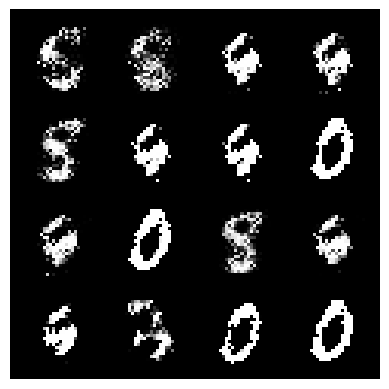

Epoch 33, step 15600: Generator loss: 7.3345949045817, discriminator loss: 0.0514051974099129


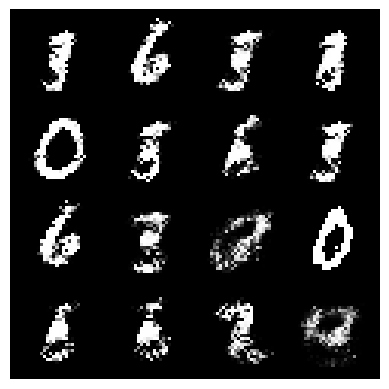

Epoch 33, step 15900: Generator loss: 7.568069966634116, discriminator loss: 0.05690953184850517


  0%|          | 0/469 [00:00<?, ?it/s]

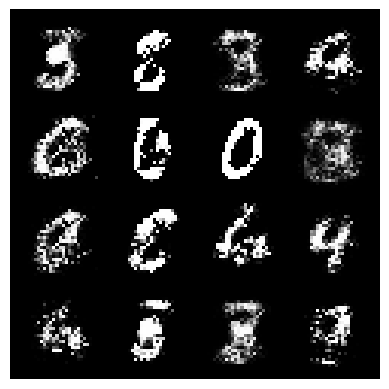

Epoch 34, step 16200: Generator loss: 6.8112145837148, discriminator loss: 0.0613057079228262


  0%|          | 0/469 [00:00<?, ?it/s]

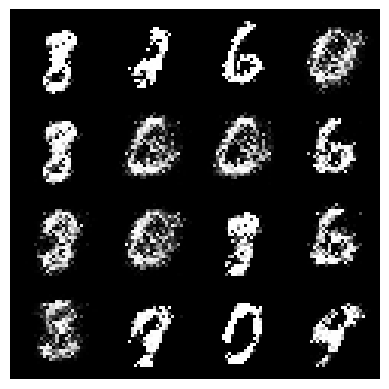

Epoch 35, step 16500: Generator loss: 6.720126417477934, discriminator loss: 0.07076188013578455


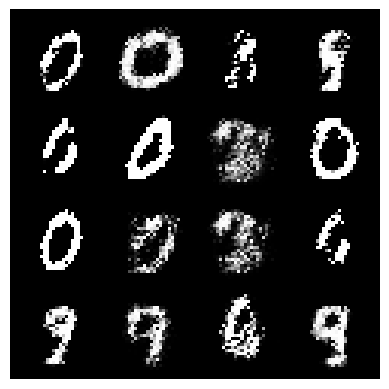

Epoch 35, step 16800: Generator loss: 6.91548104604086, discriminator loss: 0.07636699133863052


  0%|          | 0/469 [00:00<?, ?it/s]

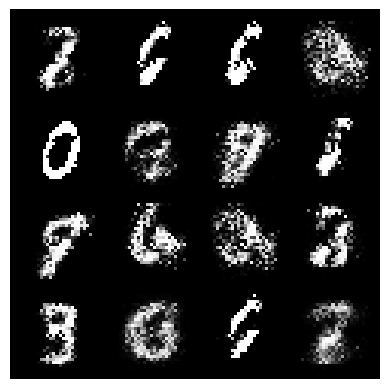

Epoch 36, step 17100: Generator loss: 6.716473515828453, discriminator loss: 0.07321498028002678


  0%|          | 0/469 [00:00<?, ?it/s]

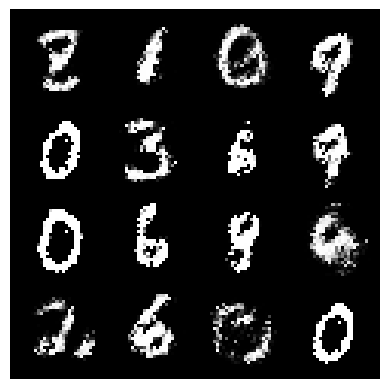

Epoch 37, step 17400: Generator loss: 6.065182833671565, discriminator loss: 0.10495848388100666


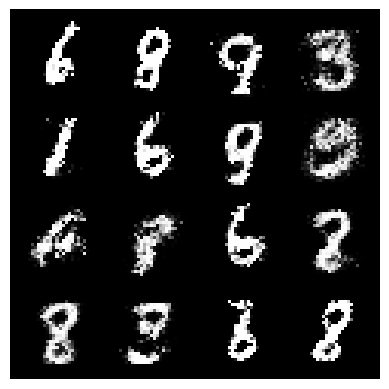

Epoch 37, step 17700: Generator loss: 6.186238916714983, discriminator loss: 0.08768076806018746


  0%|          | 0/469 [00:00<?, ?it/s]

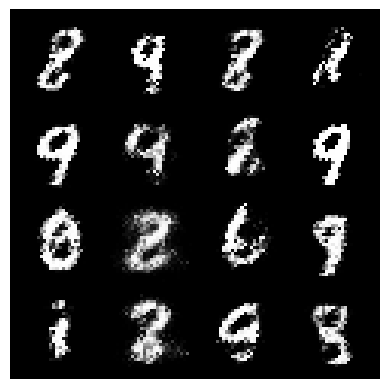

Epoch 38, step 18000: Generator loss: 5.833544730345409, discriminator loss: 0.08985984992235897


  0%|          | 0/469 [00:00<?, ?it/s]

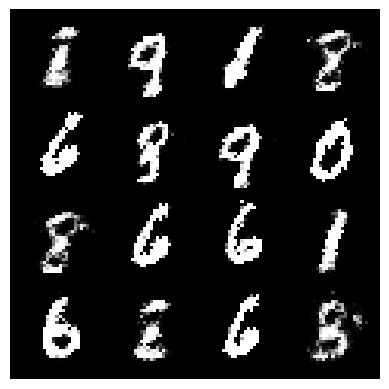

Epoch 39, step 18300: Generator loss: 5.604103378454846, discriminator loss: 0.1139489193757375


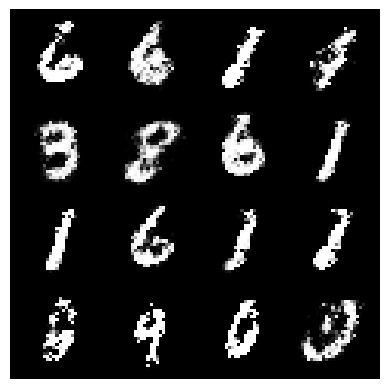

Epoch 39, step 18600: Generator loss: 4.9893285814921065, discriminator loss: 0.11706821144868942


  0%|          | 0/469 [00:00<?, ?it/s]

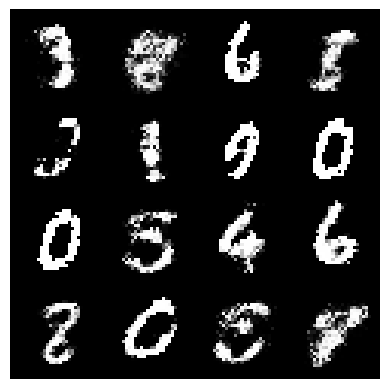

Epoch 40, step 18900: Generator loss: 5.196533149083457, discriminator loss: 0.11950270851453143


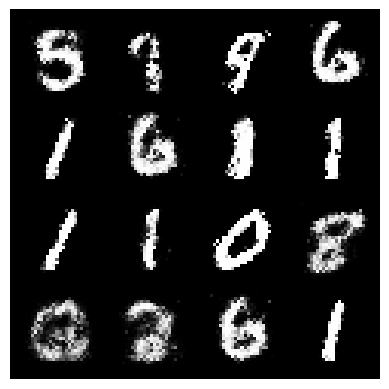

Epoch 40, step 19200: Generator loss: 5.003164308071135, discriminator loss: 0.11981101727734007


  0%|          | 0/469 [00:00<?, ?it/s]

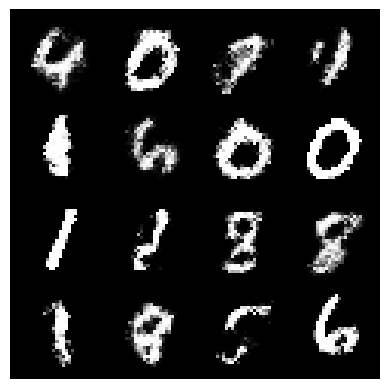

Epoch 41, step 19500: Generator loss: 4.762833327452337, discriminator loss: 0.1309547386690974


  0%|          | 0/469 [00:00<?, ?it/s]

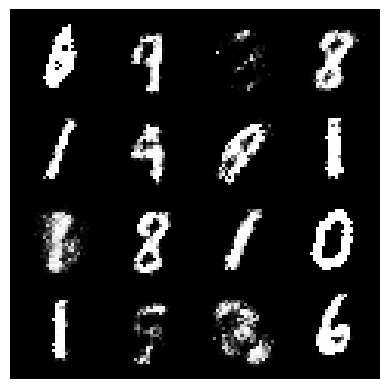

Epoch 42, step 19800: Generator loss: 4.520368994077046, discriminator loss: 0.13771856054663667


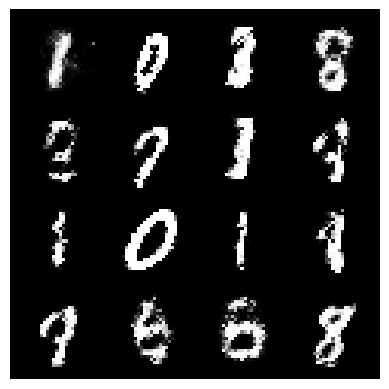

Epoch 42, step 20100: Generator loss: 4.343023930390674, discriminator loss: 0.15058448941757294


  0%|          | 0/469 [00:00<?, ?it/s]

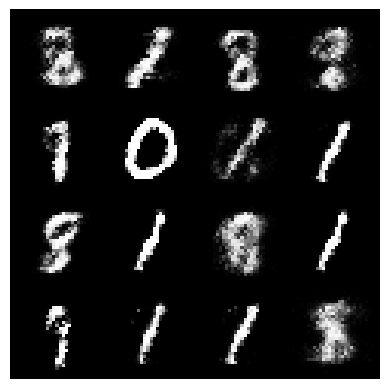

Epoch 43, step 20400: Generator loss: 4.25525900046031, discriminator loss: 0.1523081254710753


  0%|          | 0/469 [00:00<?, ?it/s]

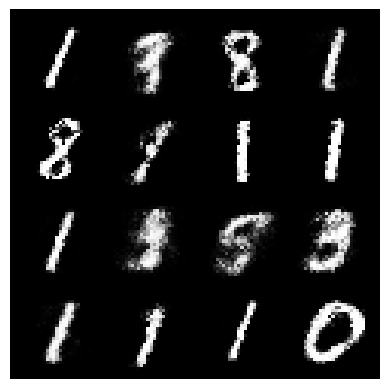

Epoch 44, step 20700: Generator loss: 4.2287695304552715, discriminator loss: 0.1597540756066641


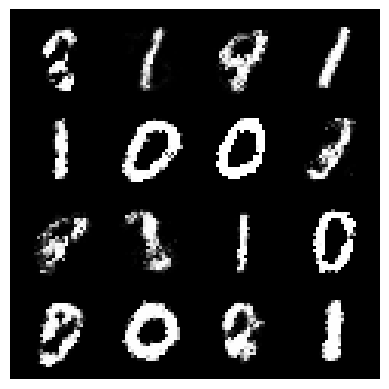

Epoch 44, step 21000: Generator loss: 3.856050280729926, discriminator loss: 0.16737946398556233


  0%|          | 0/469 [00:00<?, ?it/s]

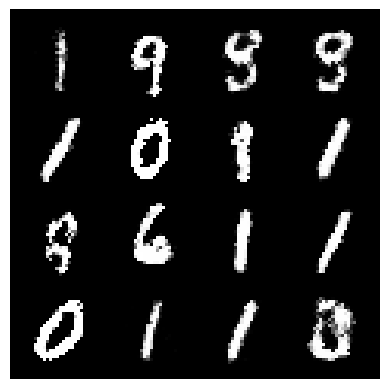

Epoch 45, step 21300: Generator loss: 3.713186843395232, discriminator loss: 0.17480623379349713


  0%|          | 0/469 [00:00<?, ?it/s]

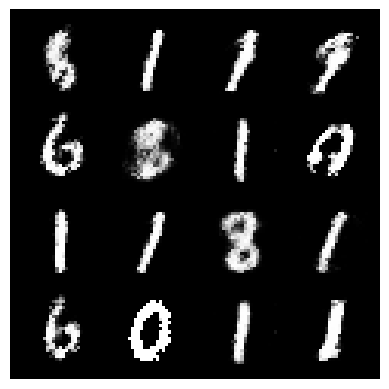

Epoch 46, step 21600: Generator loss: 3.675425810019175, discriminator loss: 0.17610263260702305


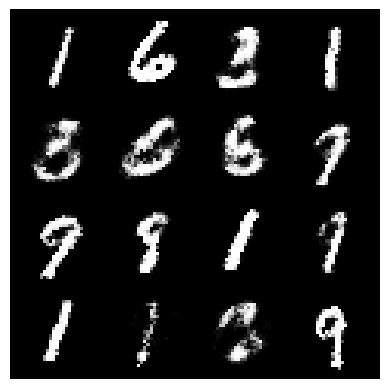

Epoch 46, step 21900: Generator loss: 3.5477373274167388, discriminator loss: 0.186128746047616


  0%|          | 0/469 [00:00<?, ?it/s]

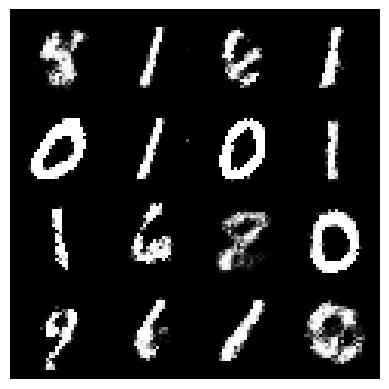

Epoch 47, step 22200: Generator loss: 3.590866592725119, discriminator loss: 0.1946979114661615


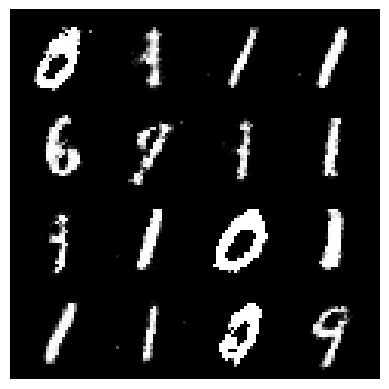

Epoch 47, step 22500: Generator loss: 3.37033045768738, discriminator loss: 0.19677126447359733


  0%|          | 0/469 [00:00<?, ?it/s]

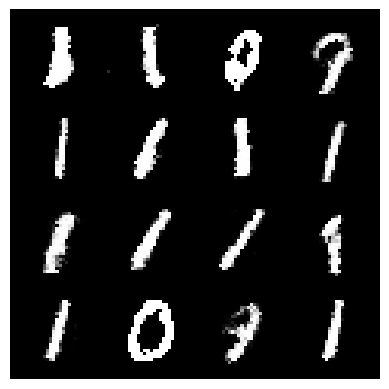

Epoch 48, step 22800: Generator loss: 3.283447073300681, discriminator loss: 0.1985956440369289


  0%|          | 0/469 [00:00<?, ?it/s]

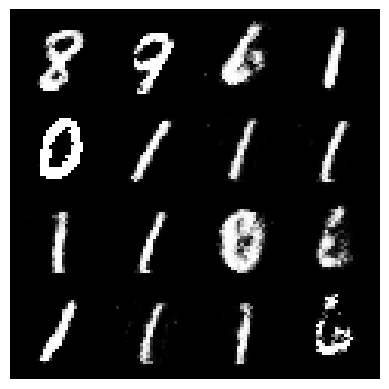

Epoch 49, step 23100: Generator loss: 3.2405894255638126, discriminator loss: 0.20417277634143827


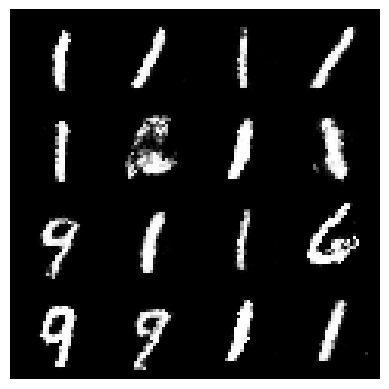

Epoch 49, step 23400: Generator loss: 3.2059322388966875, discriminator loss: 0.20684979667266198


In [55]:
for epoch in range(epochs):
  for real,_ in tqdm(data):
    disc_opt.zero_grad()

    cur_bs=len(real)
    real=real.view(cur_bs,-1)
    real=real.to(device)

    disc_loss=calc_disc_loss(loss_fn,gen,disc,real,bs,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    gen_opt.zero_grad()
    gen_loss=calc_gen_loss(loss_fn,gen,disc,bs,z_dim)
    gen_loss.backward()
    gen_opt.step()


    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step ==0 and cur_step>0:
      fake_noise=gen_noise(cur_bs,z_dim)
      fake=gen(fake_noise)
      show(fake)
      print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_gen_loss}, discriminator loss: {mean_disc_loss}")
      mean_gen_loss=0
      mean_disc_loss=0
    cur_step+=1